In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [194]:
DETECTORS_SIM = 12288
MODULES = 16
crystals_per_det = DETECTORS_SIM // MODULES

In [195]:
filename = '11_15_coin.lm'

data = np.memmap(filename, dtype=np.float32, mode='r')
data = data.reshape(-1, 10)

tofs = data[:, 3]

filename = '11_15_delay.lm'

delay = np.memmap(filename, dtype=np.float32, mode='r')
delay = delay.reshape(-1, 10)

deltofs = delay[:, 3]

filename = '11_15_actual.lm'

act = np.memmap(filename, dtype=np.float32, mode='r')
act = act.reshape(-1, 10)

acttofs = act[:, 3]

In [263]:
def match_actuals(data, act):
    datasort = np.lexsort((data[:, 3], data[:, -1], data[:, -2]))
    unsort = np.argsort(datasort)
    data = data[datasort]
    act = act[np.lexsort((act[:, 3], act[:, -1], act[:, -2]))]
    israndom = np.zeros(data.shape[0], dtype=bool)
    dat_i = 0
    act_i = 0
    while act_i < act.shape[0]:
        if (data[dat_i][3] == act[act_i][3]):
            israndom[dat_i] = True
            act_i += 1
        dat_i += 1
    return israndom[unsort]

In [651]:
def rm_random(data, delay):

    coin = np.array([
        np.concatenate(( # coin lors followed by delay lors
            data[:, 8].astype(np.int64) * DETECTORS_SIM + data[:, 9].astype(np.int64), 
            delay[:, 8].astype(np.int64) * DETECTORS_SIM + delay[:, 9].astype(np.int64)
        )),
        np.concatenate(( # zeros followed by ones
            np.zeros(data.shape[0]),
            np.ones(delay.shape[0])
        )),
        np.concatenate(( # crystal ID 1s followed by delay crystal ID 1s
            data[:, 8],
            delay[:, 8]
        )),
        np.concatenate(( # crystal ID 2s followed by delay crystal ID 2s
            data[:, 9],
            delay[:, 9]
        )),
        np.concatenate(( # TOFs followed by delay TOFs
            data[:, 3],
            delay[:, 3]
        )),
    ],dtype=np.float64)
    
    #### subtract coin events which have same nearby delay events with same LOR id.

    index = np.linspace(0, data.shape[0] + delay.shape[0] - 1, data.shape[0] + delay.shape[0], dtype = np.int64)
    print(index.size)
    #### sort based on coin/delay id << time << LOR id
    argsort = np.lexsort((coin[1,:], coin[4,:], coin[0,:]))
    coin_sorted = coin[:,argsort]
    index = index[argsort]
    prev = 0

    for i in range(1000):
        #### same LOR crystal pair but one coin and one delay
        valid = np.insert((np.diff(coin_sorted[0,]) == 0)&(np.diff(coin_sorted[1,]) == 1),0,False)
        ###               --- within same LOR        ---  and next is delay but ours is coin ---
        valid2 = (coin_sorted[1,:] == 1) # is a delay
        curr = np.sum(valid2) # number of delays
        print("residual delay: ", curr) 
        if(curr == prev or curr == 0):
            index = index[~valid2] # gets rid of remaining delays
            break
        prev = curr 
        valid = valid | (np.insert(valid[1:],valid.size - 1,False)) # insert false at end
        index = index[~valid]
        coin_sorted = coin_sorted[:,~valid]

    return index

In [629]:
def gen_sp_randoms(i, j, filename):
    def slice_sp(i, j):
        start_i = i * crystals_per_det
        stop_i = (i + 1) * crystals_per_det
        start_j = j * crystals_per_det
        stop_j = (j + 1) * crystals_per_det
        return slice(start_i, stop_i), slice(start_j, stop_j)
    
    sp = np.load(filename)
    sec = sp[slice_sp(i, j)]

    sec_int = np.floor(sec) + np.astype(np.random.rand(*sec.shape) < sec % 1, np.int64)
    sec_int = sec_int.astype(np.int64)
    sp_randoms = np.sum(sec_int)
    sp_gen = np.array([
        np.zeros(sp_randoms), np.zeros(sp_randoms), np.zeros(sp_randoms),
        np.random.rand(sp_randoms) * (np.max(tofs) - np.min(tofs)) + np.min(tofs),
        np.zeros(sp_randoms), np.zeros(sp_randoms), np.zeros(sp_randoms), np.zeros(sp_randoms),
        np.concatenate([np.full(np.int64(np.sum(sec_int[row])), row + i * crystals_per_det) for row in range(crystals_per_det)]),
        np.concat([np.repeat(np.arange(j * crystals_per_det, (j + 1) * crystals_per_det), sec_int[col]) for col in range(crystals_per_det)])
    ]).T

    return sp_gen

In [199]:
sps = gen_sp_randoms(11, 15, 'sp.npy')
sptofs = sps[:, 3]

In [685]:
delayrm = rm_random(data, delay)
actualrm = rm_random(data, act)
sprm = rm_random(data, sps)

25926759
residual delay:  8312112
residual delay:  3864135
residual delay:  2615178
residual delay:  2067407
residual delay:  1783768
residual delay:  1628232
residual delay:  1543453
residual delay:  1499370
residual delay:  1477813
residual delay:  1467889
residual delay:  1463662
residual delay:  1461917
residual delay:  1461264
residual delay:  1461039
residual delay:  1460961
residual delay:  1460930
residual delay:  1460923
residual delay:  1460919
residual delay:  1460918
residual delay:  1460918
25074613
residual delay:  7459966
residual delay:  3
residual delay:  0
24891736
residual delay:  7277089
residual delay:  3115088
residual delay:  1966836
residual delay:  1492696
residual delay:  1280637
residual delay:  1189233
residual delay:  1153672
residual delay:  1141839
residual delay:  1138466
residual delay:  1137696
residual delay:  1137552
residual delay:  1137531
residual delay:  1137525
residual delay:  1137525


In [264]:
israndom = match_actuals(data, act)

In [699]:
issort = np.arange(0, data.shape[0])[~israndom]
rsort = np.arange(0, data.shape[0])[israndom]

In [695]:
actualsort

array([       0,        1,        7, ..., 17614644, 17614645, 17614646],
      shape=(10154681,))

In [701]:
actualsort = np.sort(actualrm)
trues_kept = np.intersect1d(actualsort, issort).shape[0] / issort.shape[0]
randoms_caught = np.setdiff1d(rsort, actualsort).shape[0] / rsort.shape[0]
trues_kept, randoms_caught

(0.9999999015232482, 0.9999998659511317)

In [702]:
delsort = np.sort(delayrm)
trues_kept = np.intersect1d(delsort, issort).shape[0] / issort.shape[0]
randoms_caught = np.setdiff1d(rsort, delsort).shape[0] / rsort.shape[0]
trues_kept, randoms_caught

(0.7519478947689248, 0.5807404484149123)

In [703]:
spsort = np.sort(sprm)
trues_kept = np.intersect1d(spsort, issort).shape[0] / issort.shape[0]
randoms_caught = np.setdiff1d(rsort, spsort).shape[0] / rsort.shape[0]
trues_kept, randoms_caught

(0.7952587580052982, 0.5443030169306402)

In [686]:
delay_tofs = tofs[delayrm]
actual_tofs = tofs[actualrm]
sp_tofs = tofs[sprm]

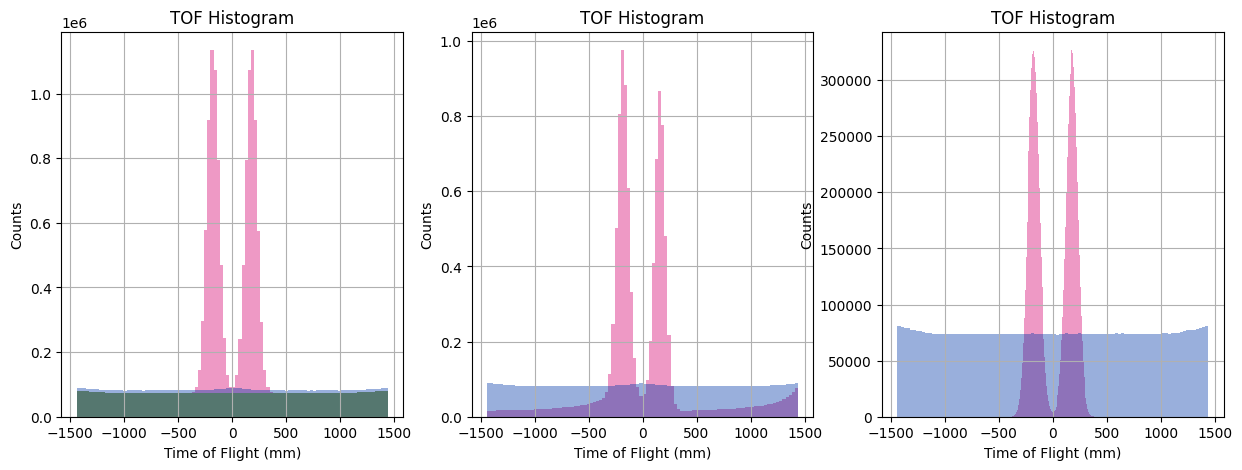

In [687]:
fig, (reg, dw, ac) = plt.subplots(1, 3, figsize=(15, 5))
reg.hist(tofs, bins=100, alpha=0.4, color='#D60270')
reg.hist(deltofs, bins=100, alpha=0.4, color='#0038A8')
reg.hist(acttofs, bins=100, alpha=0.4, color='green')
reg.set_xlabel('Time of Flight (mm)')
reg.set_ylabel('Counts')
reg.set_title('TOF Histogram')
reg.grid()

dw.hist(delay_tofs, bins=100, alpha=0.4, color='#D60270')
dw.hist(deltofs, bins=100, alpha=0.4, color='#0038A8')
dw.set_xlabel('Time of Flight (mm)')
dw.set_ylabel('Counts')
dw.set_title('TOF Histogram')
dw.grid()

ac.hist(actual_tofs, bins=100, alpha=0.4, color='#D60270')
ac.hist(acttofs, bins=100, alpha=0.4, color='#0038A8')
ac.set_xlabel('Time of Flight (mm)')
ac.set_ylabel('Counts')
ac.set_title('TOF Histogram')
ac.grid()

plt.show()

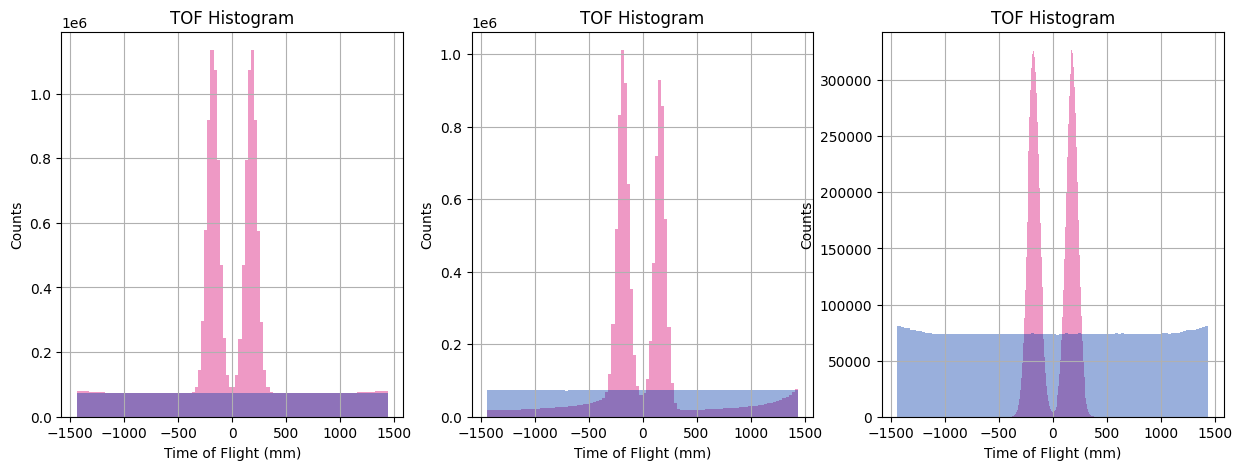

In [688]:
fig, (reg, sp, ac) = plt.subplots(1, 3, figsize=(15, 5))
reg.hist(tofs, bins=100, alpha=0.4, color='#D60270')
reg.hist(sptofs, bins=100, alpha=0.4, color='#0038A8')
reg.set_xlabel('Time of Flight (mm)')
reg.set_ylabel('Counts')
reg.set_title('TOF Histogram')
reg.grid()

sp.hist(sp_tofs, bins=100, alpha=0.4, color='#D60270')
sp.hist(sptofs, bins=100, alpha=0.4, color='#0038A8')
sp.set_xlabel('Time of Flight (mm)')
sp.set_ylabel('Counts')
sp.set_title('TOF Histogram')
sp.grid()

ac.hist(actual_tofs, bins=100, alpha=0.4, color='#D60270')
ac.hist(acttofs, bins=100, alpha=0.4, color='#0038A8')
ac.set_xlabel('Time of Flight (mm)')
ac.set_ylabel('Counts')
ac.set_title('TOF Histogram')
ac.grid()

plt.show()